# GBDT on Amazon Fine Food reviews

# 1.Loading the data

In [ ]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
download = drive.CreateFile({'id': '1K1rpp1cP61oOjKc9CIx-0v4z2SdyOpyi'})
download.GetContentFile('final.sqlite')


In [ ]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 

## 2.Spliting CleanedText and Score into train and test

In [8]:
final=final.sort_values(by=['Time'],ascending=False)
finalDataPoints=final.head(100000)
x=finalDataPoints["CleanedText"]
y=finalDataPoints["Score"]



x_tr,x_test,y_tr,y_test=train_test_split(x, y, test_size=0.2,shuffle=False)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
print(x_tr.shape,x_test.shape,y_tr.shape,y_test.shape)

(64000,) (16000,) (64000,) (16000,)


# 3.Bag of Words (BoW)

## 3.1 Unigram

In [0]:
#BOW for unigram
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)

## 3.1.1 Grid search

### 3.1.1.1 Finding the optimal nEstimator and Learning_rate using gridsearch

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 73.9min finished


Best HyperParameter:  {'learning_rate': 0.1, 'n_estimators': 500}
0.8717725200472829


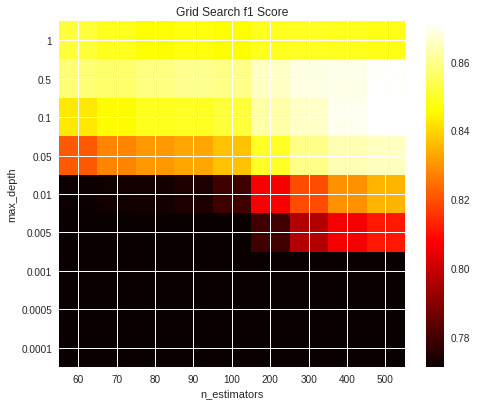

In [0]:
nEstimator = [60,70,80,90,100,200,300,400,500]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = [{'n_estimators':nEstimator,'learning_rate': learningRate}]
gsv = GridSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

### 3.1.1.2 finding the accuracy,F1-score in Test data using optimal  nEstimator and Learning_rate

Accuracy on test set: 89.595%
Precision on test set: 0.875
Recall on test set: 0.743
F1-Score on test set: 0.786


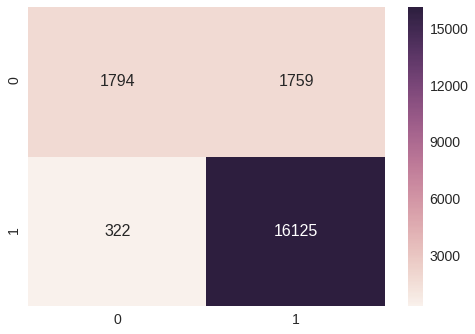

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=500)
GBC.fit(x_tr_uni,y_tr)
y_pred =GBC.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 3.1.2 RandomSearchCV

### 3.1.2.1 Finding the optimal  nEstimator and Learning_rate using RandomSearchCv

In [0]:
nEstimator = [100,200,300,400,500,600,700,800,900]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = {'n_estimators':nEstimator,'learning_rate': learningRate}
gsv = RandomizedSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 22.8min finished


Best HyperParameter:  {'n_estimators': 600, 'learning_rate': 0.1}
0.8743452143092697


### 3.1.2.2 finding the accuracy,F1-score in Test data using optimal  nEstimator and Learning_rate

Accuracy on test set: 89.585%
Precision on test set: 0.874
Recall on test set: 0.743
F1-Score on test set: 0.786


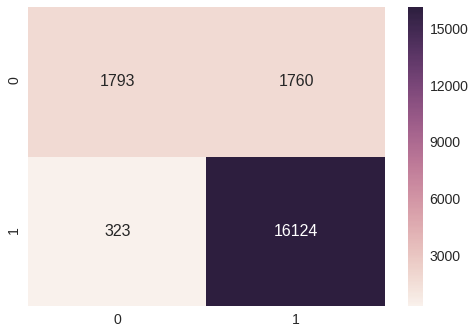

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=600)
GBC.fit(x_tr_uni,y_tr)
y_pred =GBC.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 3.1.3 Feature Importance

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=500)
GBC.fit(x_tr_uni,y_tr)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [0]:
features=(-GBC.feature_importances_).argsort()
print(np.take(bow.get_feature_names(), features[:10]))

['disappoint' 'great' 'love' 'good' 'best' 'return' 'terribl' 'aw'
 'nespresso' 'tasteless']


## 3.1.4 GBDT visualisation 

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=500)
GBC.fit(x_tr_uni,y_tr)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

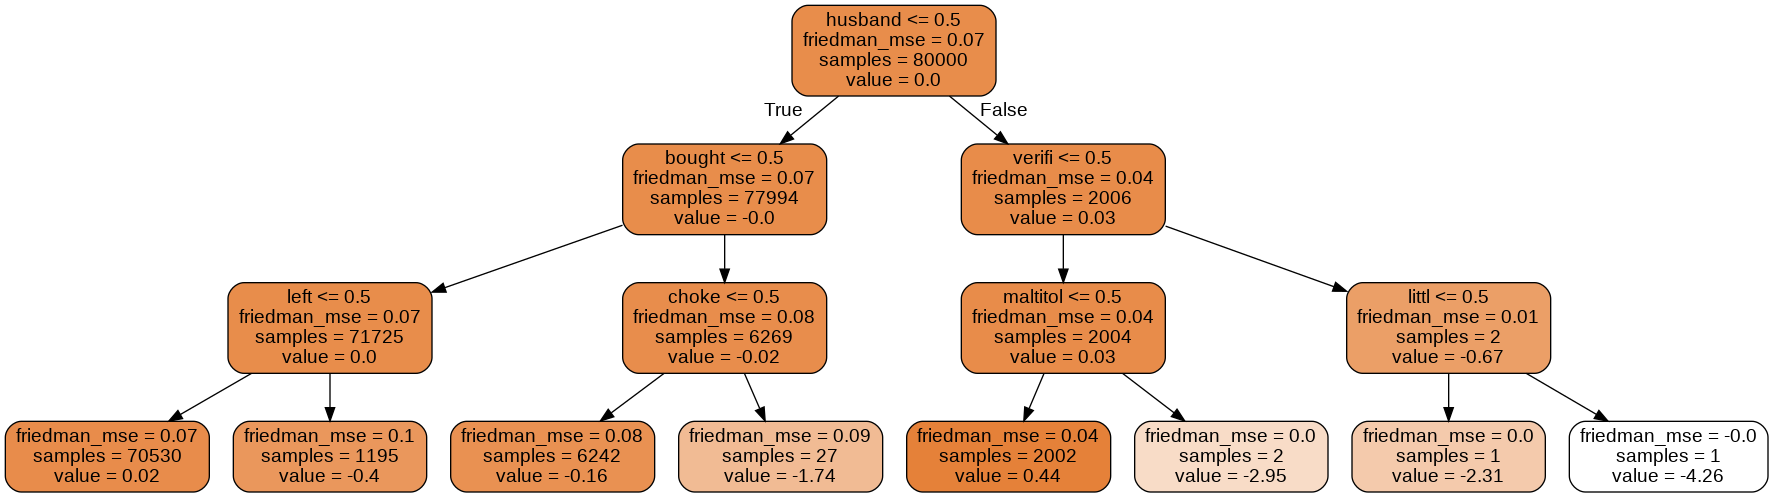

In [0]:
estimator = GBC.estimators_[450, 0]
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(estimator,feature_names=bow.get_feature_names(), out_file=dot_data,rounded = True, proportion = False,precision = 2, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 3.2 Bi-Grams


In [0]:
bi_gram = CountVectorizer(ngram_range=(1,2))
x_tr_bi = bi_gram.fit_transform(x_tr)
x_test_bi = bi_gram.transform(x_test)

## 3.2.1.1 GridSeach

### 3.2.1.1 Finding the optimal  nEstimator and Learning_rate using gridsearchcv

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 31.7min finished


Best HyperParameter:  {'learning_rate': 1, 'n_estimators': 500}
0.81280252332085


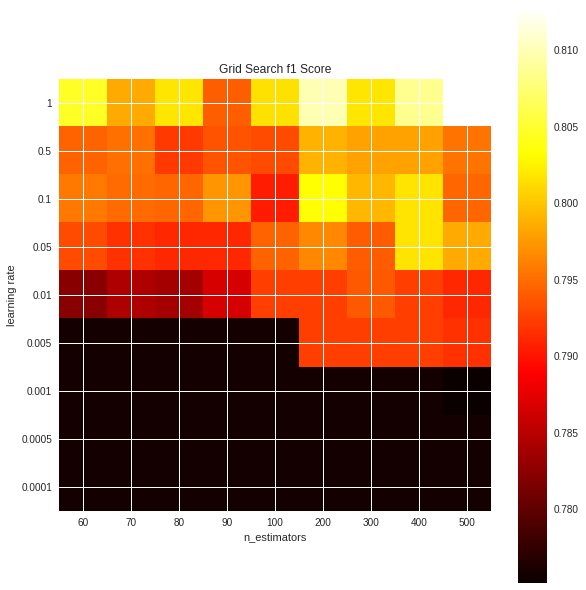

In [0]:
nEstimator = [60,70,80,90,100,200,300,400,500]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = {'n_estimators':nEstimator,'learning_rate': learningRate}
gsv = GridSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(learningRate))

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('learning rate')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(learningRate)), learningRate)
plt.title('Grid Search f1 Score')
plt.show()

### 3.2.1.2 finding the accuracy in Test data using optimal nEstimator and Learning_rate

Accuracy on test set: 89.580%
Precision on test set: 0.842
Recall on test set: 0.777
F1-Score on test set: 0.804


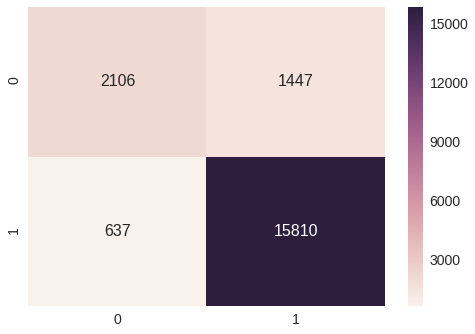

In [0]:
GBC= GradientBoostingClassifier(learning_rate=1,n_estimators=500)
GBC.fit(x_tr_bi,y_tr)
y_pred =GBC.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 3.2.1.2 Randomseachcv

### 3.2.1.1 Finding the optimal nEstimator and Learning_rate using RandomSearchCv

In [0]:
nEstimator = [60,70,80,90,100,200,300,400,500]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = {'n_estimators':nEstimator,'learning_rate': learningRate}
gsv = RandomizedSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


Best HyperParameter:  {'n_estimators': 500, 'learning_rate': 1}


### 3.2.1.2 finding the accuracy in Test data using optimal nEstimator and Learning_rate

Accuracy on test set: 89.580%
Precision on test set: 0.842
Recall on test set: 0.777
F1-Score on test set: 0.804


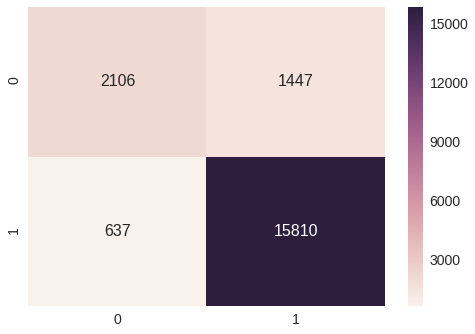

In [0]:
GBC= GradientBoostingClassifier(learning_rate=1,n_estimators=500)
GBC.fit(x_tr_bi,y_tr)
y_pred =GBC.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 3.2.3 Feature Importance

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=500)
GBC.fit(x_tr_bi,y_tr)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [0]:
features=(-GBC.feature_importances_).argsort()
print(np.take(bi_gram.get_feature_names(), features[:10]))

['disappoint' 'great' 'good' 'return' 'love' 'best' 'aw' 'stale'
 'tasteless' 'terribl']


## 3.1.4 GBDT visualisation 

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.5,n_estimators=500)
GBC.fit(x_tr_bi,y_tr)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

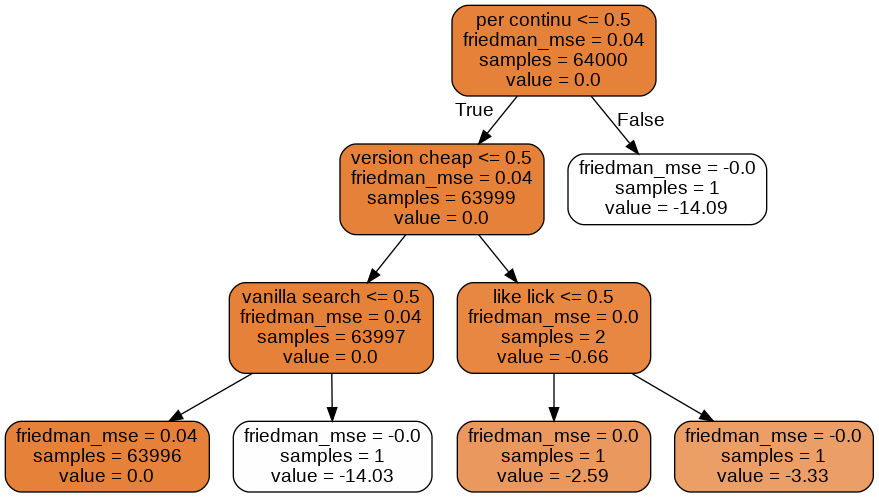

In [0]:
estimator = GBC.estimators_[450, 0]
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(estimator, feature_names=bi_gram.get_feature_names(),out_file=dot_data,rounded = True, proportion = False,precision = 2, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 4 TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)

# 4.1 GridSearch

## 4.1.1 Finding the optimal nEstimator and Learning_rate using GridsearchCv

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 33.4min finished


Best HyperParameter:  {'learning_rate': 0.5, 'n_estimators': 500}
0.8023945582118652


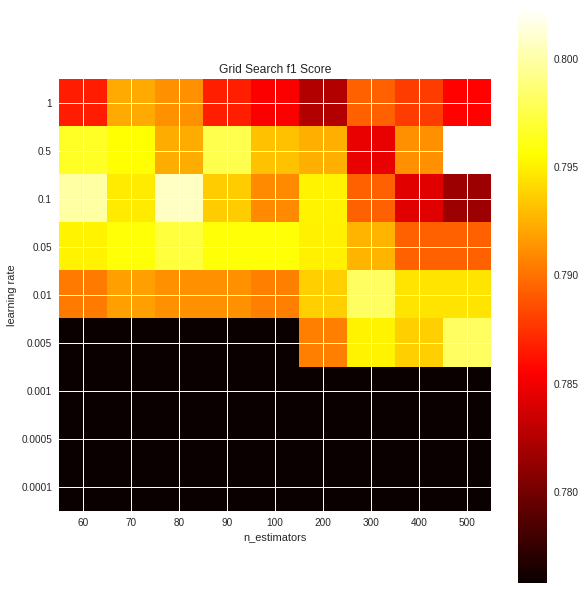

In [0]:
nEstimator = [60,70,80,90,100,200,300,400,500]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = {'n_estimators':nEstimator,'learning_rate': learningRate}
gsv = GridSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_tfidf,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(learningRate))

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('learning rate')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(learningRate)), learningRate)
plt.title('Grid Search f1 Score')
plt.show()

## 4.1.2 finding the accuracy in Test data using optimal nEstimator and Learning_rate

Accuracy on test set: 90.055%
Precision on test set: 0.853
Recall on test set: 0.785
F1-Score on test set: 0.812


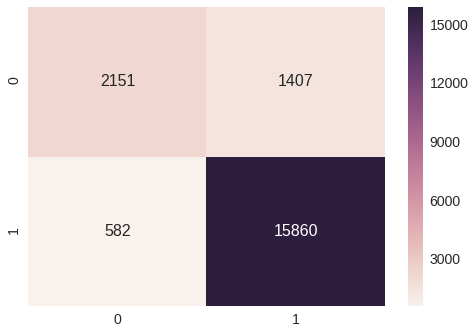

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.5,n_estimators=500)
GBC.fit(x_tr_tfidf,y_tr)
y_pred =GBC.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 4.2 RandomSearchCv

## 4.2.1 Finding the optimal nEstimator and Learning_rate using RandomSearchCv

In [0]:
nEstimator = [60,70,80,90,100,200,300,400,500]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = {'n_estimators':nEstimator,'learning_rate': learningRate}
gsv = RandomizedSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_tfidf,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.6min finished


Best HyperParameter:  {'n_estimators': 400, 'learning_rate': 0.005}
0.7943751447191916


## 4.2.2 finding the accuracy in Test data using optimal nEstimator and Learning_rate

Accuracy on test set: 89.960%
Precision on test set: 0.882
Recall on test set: 0.752
F1-Score on test set: 0.795


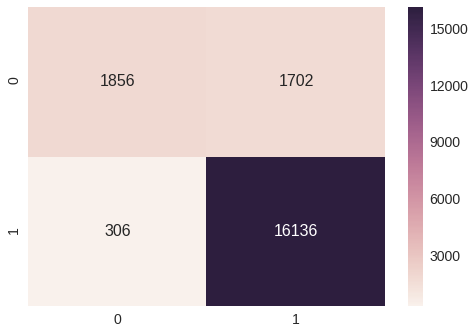

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=500)
GBC.fit(x_tr_tfidf,y_tr)
y_pred =GBC.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 4.1.3 Feature Importance

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=500)
GBC.fit(x_tr_tfidf,y_tr)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [0]:
features=(-GBC.feature_importances_).argsort()
print(np.take(tf_idf_vect.get_feature_names(), features[:10]))

['disappoint' 'great' 'love' 'return' 'stale' 'aw' 'good' 'horribl'
 'terribl' 'nespresso']


## 4.1.4 GBDT visualisation 

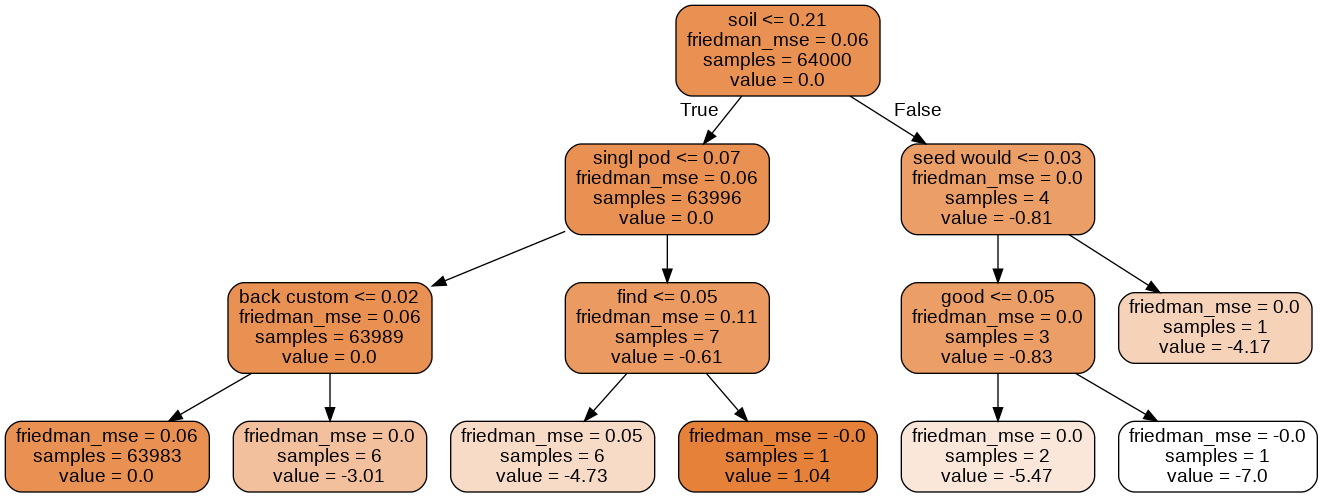

In [11]:
GBC= GradientBoostingClassifier(learning_rate=0.5,n_estimators=500)
GBC.fit(x_tr_tfidf,y_tr)
estimator = GBC.estimators_[100, 0]
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(estimator,feature_names=tf_idf_vect.get_feature_names(), out_file=dot_data,rounded = True, proportion = False,precision = 2, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 5 Word2Vec

In [0]:
i=0
list_of_sent=[]
for sent in x_tr:
    list_of_sent.append(sent.split())
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [22]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10154
sample words  ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'mission', 'must', 'tri', 'hard', 'ever', 'write', 'review', 'rice', 'good', 'live', 'hawaii', 'never', 'seen', 'caribbean', 'sale', 'store', 'came', 'across', 'search', 'amazon', 'glad', 'gave', 'think', 'youll', 'disappoint', 'ad', 'chop', 'chicken', 'suggest', 'also', 'small', 'onion', 'unbeliev', 'anoth', 'great', 'way', 'make', 'even', 'better', 'fresh']


# 6.Avg W2V

In [23]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

64000
50


In [24]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

16000
50


In [0]:
x_test_av1=sent_vectors_test
x_tr_av1=sent_vectors

# 6.1 Gridsearch

## 6.1.1 Finding the optimal nEstimator and Learning_rate using GridSearchcv 

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 34.1min finished


Best HyperParameter:  {'learning_rate': 0.5, 'n_estimators': 60}
0.828986536427702


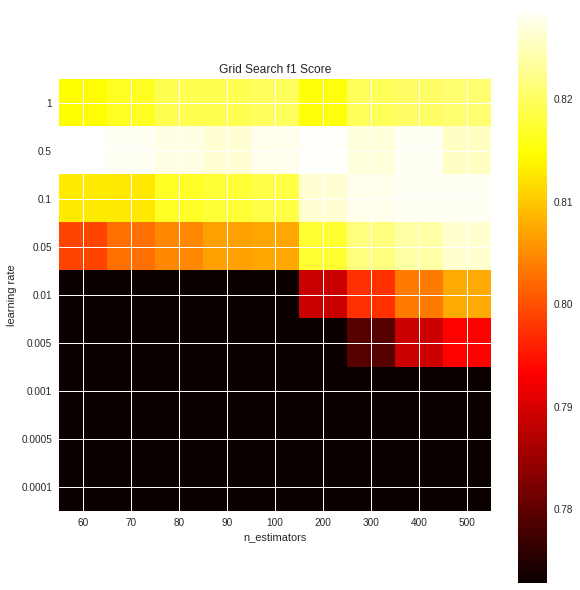

In [0]:
nEstimator = [60,70,80,90,100,200,300,400,500]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = {'n_estimators':nEstimator,'learning_rate': learningRate}
gsv = GridSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(learningRate))

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('learning rate')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(learningRate)), learningRate)
plt.title('Grid Search f1 Score')
plt.show()

## 6.1.2 finding the accuracy in Test data using optimal nEstimator and Learning_rate

Accuracy on test set: 88.390%
Precision on test set: 0.822
Recall on test set: 0.748
F1-Score on test set: 0.777


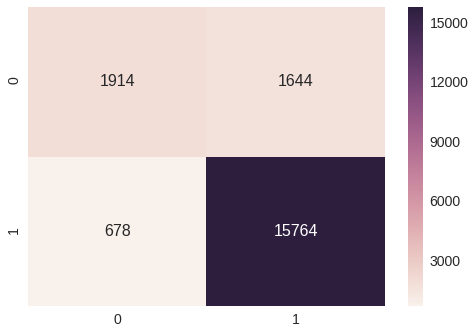

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.5,n_estimators=60)
GBC.fit(x_tr_av1,y_tr)
y_pred =GBC.predict(x_test_av1)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 6.2 RandomSearchCv

## 6.2.1 Finding the optimal nEstimator and Learning_rate using RandomSearchCv

In [0]:
nEstimator = [60,70,80,90,100,200,300,400,500]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = {'n_estimators':nEstimator,'learning_rate': learningRate}
gsv = RandomizedSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished


Best HyperParameter:  {'n_estimators': 70, 'learning_rate': 0.1}
0.8150566790506939


## 6.2.2 Finding the optimal nEstimator and Learning_rate using GridSearch

Accuracy on test set: 87.315%
Precision on test set: 0.832
Recall on test set: 0.687
F1-Score on test set: 0.727


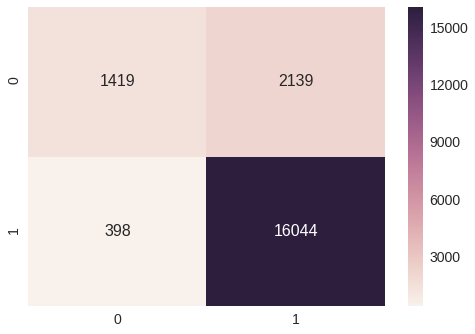

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=70)
GBC.fit(x_tr_av1,y_tr)
y_pred =GBC.predict(x_test_av1)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 6.1.4 RandomForest visualisation 

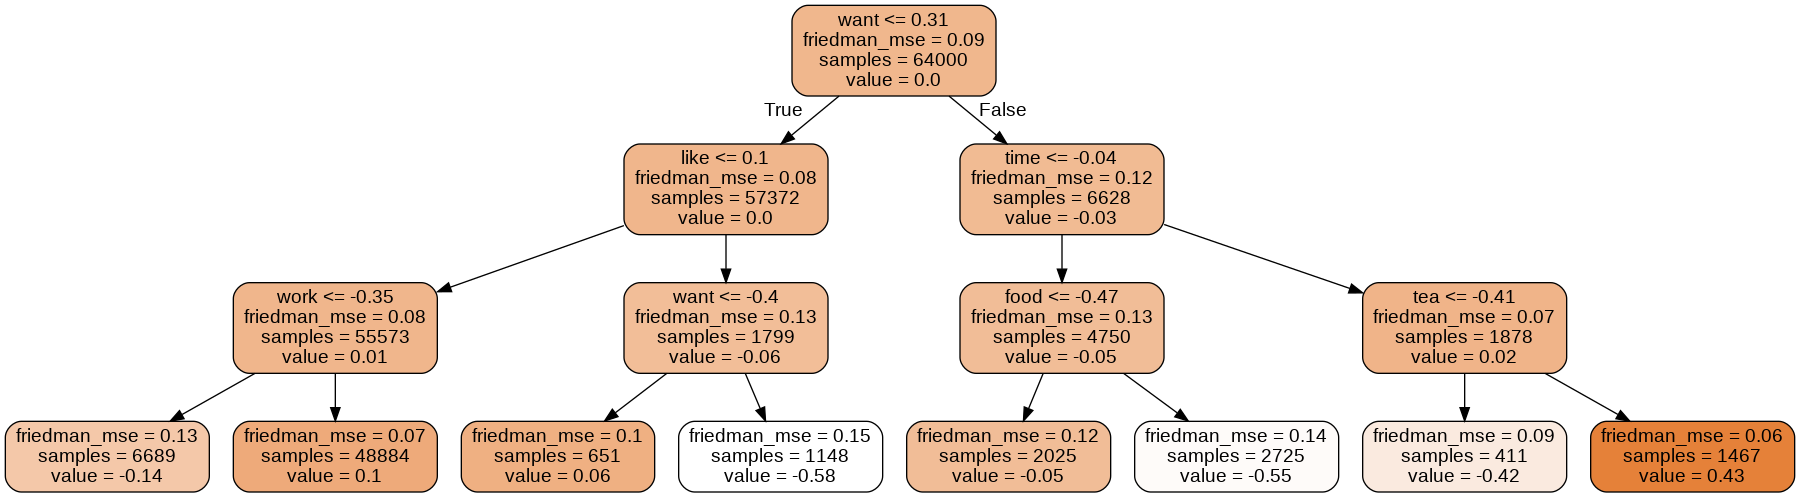

In [28]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=70)
GBC.fit(x_tr_av1,y_tr)
estimator = GBC.estimators_[69, 0]
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(estimator,feature_names=w2v_model.wv.index2word[:50], out_file=dot_data,rounded = True, proportion = False,precision = 2, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 7. TFIDF-W2V

In [0]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_tr)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [30]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 64000/64000 [01:57<00:00, 546.94it/s]


In [31]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 16000/16000 [00:31<00:00, 509.47it/s]


In [0]:
x_test_tdfw2v=tfidf_sent_vectors_test
x_tr_tdfw2v=tfidf_sent_vectors

## 7.1 GridSearch

### 7.1.1 Finding the optimal nEstimator and Learning_rate using GridSearch

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 37.4min finished


Best HyperParameter:  {'learning_rate': 0.1, 'n_estimators': 500}
0.8150255239247235


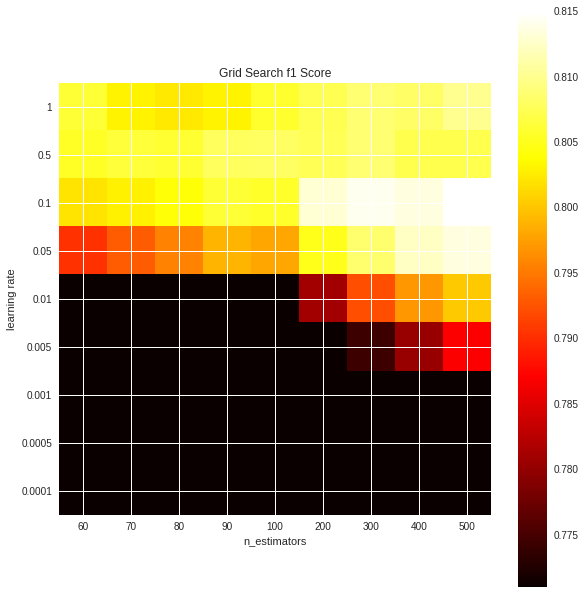

In [0]:
nEstimator = [60,70,80,90,100,200,300,400,500]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = {'n_estimators':nEstimator,'learning_rate': learningRate}
gsv = GridSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_tdfw2v,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(learningRate))

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('learning rate')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(learningRate)), learningRate)
plt.title('Grid Search f1 Score')
plt.show()

### 7.1.2 finding the accuracy in Test data using optimal nEstimator and Learning_rate

Accuracy on test set: 87.545%
Precision on test set: 0.819
Recall on test set: 0.710
F1-Score on test set: 0.746


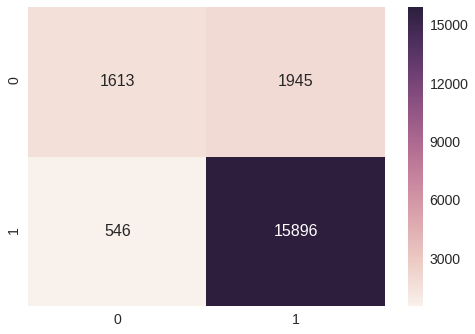

In [0]:
GBC= GradientBoostingClassifier(learning_rate=0.1,n_estimators=500)
GBC.fit(x_tr_tdfw2v,y_tr)
y_pred =GBC.predict(x_test_tdfw2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# 7.2 RandomSearchcv


### 7.2.1 Finding the optimal nEstimator and Learning_rate using RandomSearch

In [0]:
nEstimator = [60,70,80,90,100,200,300,400,500]
learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

GBC = GradientBoostingClassifier()
hyperParam = {'n_estimators':nEstimator,'learning_rate': learningRate}
gsv = RandomizedSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_tdfw2v,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.2min finished


Best HyperParameter:  {'n_estimators': 500, 'learning_rate': 0.1}
0.8028713464917699


## 7.1.2 finding the accuracy in Test data using optimal nEstimator and Learning_rate

Accuracy on test set: 87.540%
Precision on test set: 0.819
Recall on test set: 0.710
F1-Score on test set: 0.746


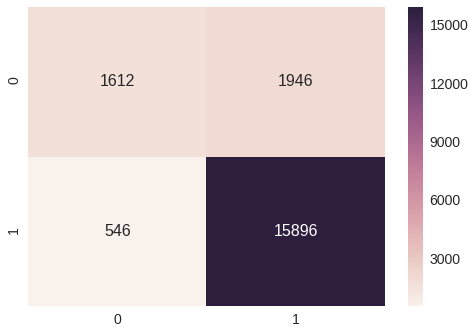

In [0]:
GBC = GradientBoostingClassifier(n_estimators=500,learning_rate=0.1)
GBC.fit(x_tr_tdfw2v,y_tr)
y_pred =GBC.predict(x_test_tdfw2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 7.1.3 GBDT visualisation 

In [33]:
GBC= GradientBoostingClassifier(learning_rate=0.5,n_estimators=500)
GBC.fit(x_tr_tdfw2v,y_tr)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

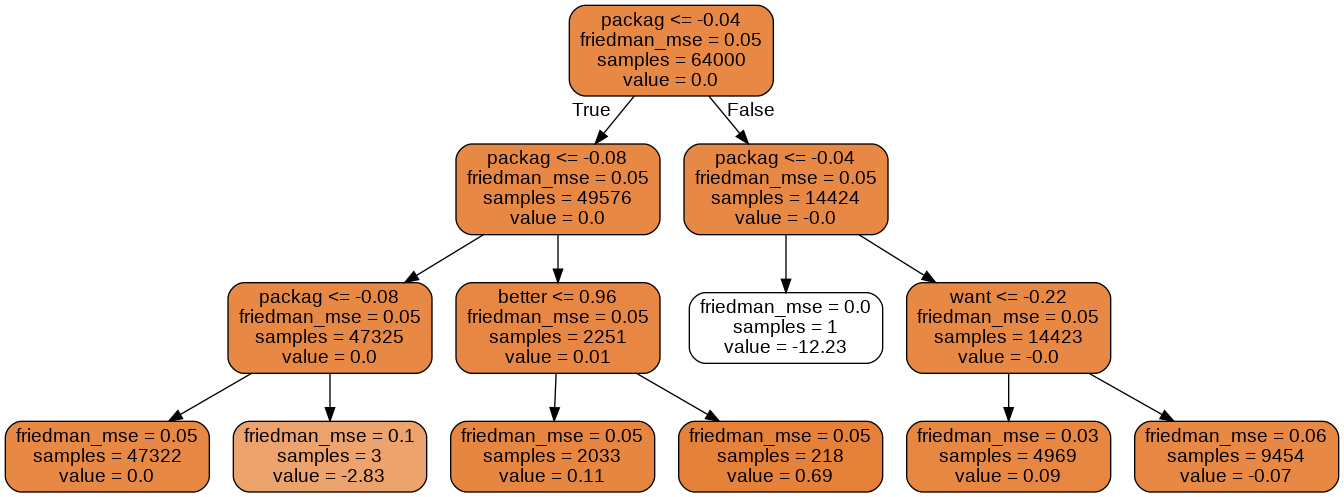

In [35]:
estimator = GBC.estimators_[499, 0]
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(estimator,feature_names=w2v_model.wv.index2word[:50], out_file=dot_data,rounded = True, proportion = False,precision = 2, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# GridSearch Conclusion

In [2]:
import pandas as pd
resultGridSearch = {
    
    'Model': ['unigram', 'Bi-gram', 'Tf-IDF', 'Av-Word2Vec','Tf-IDF Word2vec'],
    'learning Rate': ['0.1', '1', '0.5', '0.5','0.1'],
    'n_estimator': [500,500,500,60,500],
    'F1score test': [0.786,0.804,0.812,0.777,0.746],
    'accuracy Test': ['89.595%','89.580%','90.055%','88.390%','87.745%']
}
pd.DataFrame(resultGridSearch)

,Model,learning Rate,n_estimator,F1score test,accuracy Test
0,unigram,0.1,500,0.786,89.595%
1,Bi-gram,1,500,0.804,89.580%
2,Tf-IDF,0.5,500,0.812,90.055%
3,Av-Word2Vec,0.5,60,0.777,88.390%
4,Tf-IDF Word2vec,0.1,500,0.746,87.745%


# RandomSearch Conclusion

In [3]:
resultRandomSearch = {
    
    'Model': ['unigram', 'Bi-gram', 'Tf-IDF', 'Av-Word2Vec','Tf-IDF Word2vec'],
    'Learning Rate': ['0.1', '1', '0.005', '0.1','0.1'],
    'n_estimator': [600,500,400,70,500],
    'F1score test': [0.786,0.804,0.795,0.727,0.746],
    'accuracy Test': ['89.595%','89.580%','89.950%','87.315%','87.540%']
}
pd.DataFrame(resultRandomSearch)

,Model,Learning Rate,n_estimator,F1score test,accuracy Test
0,unigram,0.1,600,0.786,89.595%
1,Bi-gram,1,500,0.804,89.580%
2,Tf-IDF,0.005,400,0.795,89.950%
3,Av-Word2Vec,0.1,70,0.727,87.315%
4,Tf-IDF Word2vec,0.1,500,0.746,87.540%
